# Einführung in NetworKit

* Beispiel-Evaluation
* Installation
* Tour durch den Code

Ziel: 

* Weiteres Verständnis von Louvain/Leiden und Modularity
* Vorbereitung/Einstieg für das Mini-Praktikum
* Überblick über NetworKit

NetworKit (https://networkit.github.io/):

* Algorithmen und Datenstrukturen in C++
* Python-Interface mit Hilfe von Cython

In [1]:
import networkit as nk

## Graph Einlesen

In [2]:
G = nk.readGraph("/home/michael/graphs/football.graph", nk.Format.METIS)

In [3]:
G = nk.readGraph("/home/michael/graphs/com-amazon.ungraph.txt", nk.Format.SNAP)

In [4]:
G = nk.graphio.readMat("/home/michael/graphs/facebook100/Caltech36.mat", key="A")

In [5]:
G.numberOfNodes()

769

In [6]:
G.numberOfEdges()

16656

In [7]:
G.numberOfSelfLoops()

0

In [8]:
G.isWeighted()

False

## PLM /Louvain

In [9]:
?nk.community.PLM

In [10]:
plm = nk.community.PLM(G, par="none randomized", refine=True)

In [11]:
plm.run()

In [12]:
P = plm.getPartition()

In [13]:
P.numberOfSubsets()

11

In [14]:
P2 = nk.community.PLM(G, par="none randomized", refine=True).run().getPartition()

In [15]:
1.0 - nk.community.NMIDistance().getDissimilarity(G, P, P2)

0.8641288645729583

In [16]:
1.0 - nk.community.AdjustedRandMeasure().getDissimilarity(G, P, P2)

0.8304136206068062

## LFR

In [17]:
def genLFR(n, mu):
    lfr = nk.generators.LFRGenerator(n)
    lfr.generatePowerlawDegreeSequence(20, 50, -2)
    lfr.generatePowerlawCommunitySizeSequence(20, 100, -1)
    lfr.setMu(mu)
    lfr.run()
    return (lfr.getGraph(), lfr.getPartition())

In [18]:
Glfr, Plfr = genLFR(1000, 0.2)

In [19]:
Plouvain = nk.community.PLM(Glfr, par="none randomized").run().getPartition()

In [20]:
1.0 - nk.community.AdjustedRandMeasure().getDissimilarity(Glfr, Plfr, Plouvain)

1.0

## Evaluation mit LFR

In [21]:
mus = [i/10 for i in range(1, 10)]

In [22]:
aris_louvain = []
nmis_louvain = []
for mu in mus:
    Glfr, Plfr = genLFR(1000, mu)
    Plouvain = nk.community.PLM(Glfr, par="none randomized").run().getPartition()
    aris_louvain.append(1.0 - nk.community.AdjustedRandMeasure().getDissimilarity(Glfr, Plfr, Plouvain))
    nmis_louvain.append(1.0 - nk.community.NMIDistance().getDissimilarity(Glfr, Plfr, Plouvain))

In [23]:
import matplotlib.pyplot as plt

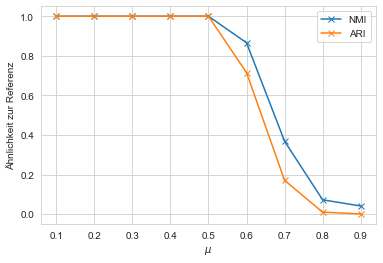

In [24]:
fig, ax = plt.subplots()
ax.plot(mus, nmis_louvain, "x-", label="NMI")
ax.plot(mus, aris_louvain, "x-", label="ARI")
ax.set_xlabel("$\mu$")
ax.set_ylabel("Ähnlichkeit zur Referenz")
ax.legend()

## Vergleich mit Leiden

https://github.com/vtraag/leidenalg

In [25]:
import leidenalg

In [26]:
import igraph as ig

In [29]:
aris_louvain = []
nmis_louvain = []
aris_leiden = []
nmis_leiden = []
for mu in mus:
    Glfr, Plfr = genLFR(1000, mu)
    Plouvain = nk.community.PLM(Glfr, par="none randomized").run().getPartition()
    aris_louvain.append(1.0 - nk.community.AdjustedRandMeasure().getDissimilarity(Glfr, Plfr, Plouvain))
    nmis_louvain.append(1.0 - nk.community.NMIDistance().getDissimilarity(Glfr, Plfr, Plouvain))

    Glfrig = ig.Graph(Glfr.numberOfNodes(), Glfr.iterEdges())
    Pleiden = leidenalg.find_partition(Glfrig, leidenalg.ModularityVertexPartition, n_iterations=20)
    Pnkleiden = nk.Partition(Glfr.numberOfNodes())
    Pnkleiden.setUpperBound(len(Pleiden))
    for i, c in enumerate(Pleiden):
        for u in c:
            Pnkleiden[u] = i
    
    aris_leiden.append(1.0 - nk.community.AdjustedRandMeasure().getDissimilarity(Glfr, Plfr, Pnkleiden))
    nmis_leiden.append(1.0 - nk.community.NMIDistance().getDissimilarity(Glfr, Plfr, Pnkleiden))


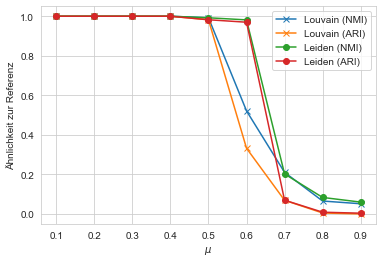

In [30]:
fig, ax = plt.subplots()
ax.plot(mus, nmis_louvain, "x-", label="Louvain (NMI)")
ax.plot(mus, aris_louvain, "x-", label="Louvain (ARI)")
ax.plot(mus, nmis_leiden, "o-", label="Leiden (NMI)")
ax.plot(mus, aris_leiden, "o-", label="Leiden (ARI)")

ax.set_xlabel("$\mu$")
ax.set_ylabel("Ähnlichkeit zur Referenz")
ax.legend()

## Clustergrößen - Resolution Limit

In [38]:
Glfr, Plfr = genLFR(10000, 0.2)
Glfrig = ig.Graph(Glfr.numberOfNodes(), Glfr.iterEdges())
Pleiden = leidenalg.find_partition(Glfrig, leidenalg.ModularityVertexPartition, n_iterations=20, initial_membership=[Plfr[u] for u in Glfr.iterNodes()])

Pnkleiden = nk.Partition(Glfr.numberOfNodes())
Pnkleiden.setUpperBound(len(Pleiden))
for i, c in enumerate(Pleiden):
    for u in c:
        Pnkleiden[u] = i


In [39]:
Plfr.numberOfSubsets()

193

In [40]:
Pnkleiden.numberOfSubsets()

140

(array([ 0., 37., 37., 27., 22., 24.,  9., 22., 13.,  2.]),
 array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110]),
 <BarContainer object of 10 artists>)

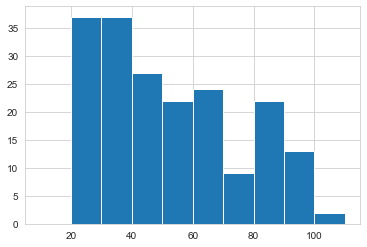

In [41]:
plt.hist(Plfr.subsetSizes(), bins=range(10, 120, 10))

(array([ 0.,  1.,  5., 17., 22., 20., 20., 28., 16.,  6.,  4.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.]),
 array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
        140, 150, 160, 170, 180, 190]),
 <BarContainer object of 18 artists>)

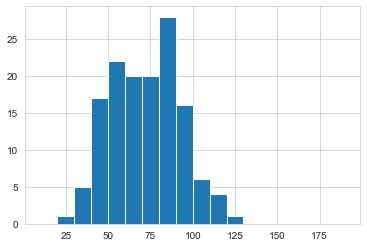

In [42]:
plt.hist(Pnkleiden.subsetSizes(), bins=range(10, 200, 10))

In [43]:
nk.community.Modularity().getQuality(Plfr, Glfr)

0.778296088007561

In [44]:
nk.community.Modularity().getQuality(Pnkleiden, Glfr)

0.7788281976060446

In [45]:
1.0 - nk.community.AdjustedRandMeasure().getDissimilarity(Glfr, Plfr, Pnkleiden)

0.8885814380250846

In [46]:
1.0 - nk.community.NMIDistance().getDissimilarity(Glfr, Plfr, Pnkleiden)

0.9737255258334966

## Installation

Empfehlung:

* virtuelle Umgebung anlegen mit venv https://docs.python.org/3/tutorial/venv.html - `python3 -m venv vorlesung-venv`
* Virtuelle Umgebung mit `source vorlesung-venv/bin/activate` aktivieren
* Cython mit `pip install cython` installieren
* NetworKit mit `pip install -e .` (aus dem NetworKit-Verzeichnis heraus) installieren
* Weitere hilfreiche Pakete: `pip install jupyter matplotlib seaborn`

Tests in C++, Code-Stil etc.: https://networkit.github.io/dev-docs/DevGuide.html